In [9]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeClassifier import EdgeClassNet
from torch.optim import Adam

In [10]:
# run only if new data is desired
ode_dim = 2
n_data = 2
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset = []
for i in range(0,len(x_train)):

    y = torch.zeros(len(y_train[i]))
    for j in range(0,len(y_train[i])):
        if y_train[i][j] > 0.0001:
            y[j] = 1
        if y_train[i][j] < -0.0001:
            y[j] = 2
    y = y.long()
    dataset.append(to_pyg_data(x_train[i],y,ode_dim,n_data))

loader = DataLoader(dataset,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    y = torch.zeros(len(y_test[i]))
    for j in range(0,len(y_test[i])):
        if y_test[i][j] > 0.0001:
            y[j] = 1
        if y_test[i][j] < -0.0001:
            y[j] = 2
    y = y.long()
    dataset.append(to_pyg_data(x_test[i],y,ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [11]:
model = EdgeClassNet(n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
class_loss = torch.nn.NLLLoss()
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(3000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = class_loss(out,data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = class_loss(out,data.y)
            # print(loss.item())
            test_loss.append(loss)

346.95416259765625
314.4494323730469
283.3277282714844
279.1194152832031
277.9560852050781
277.3464660644531
276.8380432128906
276.58953857421875
276.204345703125
275.9006042480469
275.71929931640625
275.5162658691406
275.27001953125
275.1197814941406
274.9251708984375
274.7873229980469
274.79998779296875
274.6636657714844
274.55084228515625
274.5260314941406
274.4651184082031
274.2260437011719
274.1084289550781
274.13592529296875
274.0289001464844
273.9457702636719
273.8380432128906
273.7646179199219
273.5760803222656
273.4691467285156
273.429931640625
273.3265686035156
273.24444580078125
273.1056823730469
273.0254211425781
273.00775146484375
272.8385314941406
272.7477111816406
272.75775146484375
272.6063537597656
272.4488220214844
272.46685791015625
272.33935546875
272.362548828125
272.1461181640625
272.11126708984375
272.0102233886719
271.94158935546875
271.9021301269531
271.814697265625
271.78955078125
271.7295837402344
271.6799011230469
271.393798828125
271.4139709472656
271.33569

KeyboardInterrupt: 

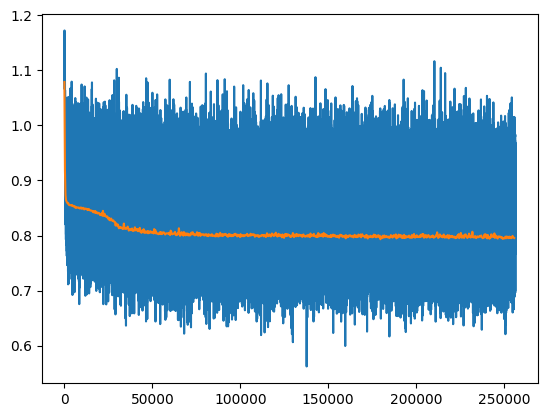

tensor([ 0.,  0., -1., -1.])
tensor([ 0., -1.,  0.,  0.])
tensor([-1., -1.,  0.,  0.])
tensor([0., 1., 1., 0.])
tensor([ 1.,  0., -1., -1.])
tensor([ 1., -1., -1.,  1.])
tensor([ 0., -1., -1., -1.])
tensor([1., 1., 0., 0.])
tensor([ 0., -1.,  0.,  0.])
tensor([-1.,  0.,  0., -1.])
tensor([ 0., -1.,  0.,  1.])
tensor([-1.,  1., -1.,  0.])
tensor([-1., -1., -1.,  0.])
tensor([-1.,  0., -1., -1.])
tensor([-1., -1., -1.,  0.])
tensor([-1.,  1., -1.,  0.])
tensor([-1., -1.,  1.,  0.])
tensor([-1.,  1.,  1.,  0.])
tensor([0., 1., 1., 0.])
tensor([ 1.,  1.,  0., -1.])
tensor([-1.,  0., -1., -1.])
tensor([-1.,  0., -1.,  1.])
tensor([ 1., -1.,  0.,  1.])
tensor([-1.,  0.,  0., -1.])
tensor([-1.,  0., -1., -1.])
tensor([-1.,  0.,  0., -1.])
tensor([ 0., -1.,  0., -1.])
tensor([ 1.,  1.,  0., -1.])
tensor([ 0., -1.,  1.,  0.])
tensor([ 0., -1.,  0., -1.])
tensor([-1.,  0.,  1.,  0.])
tensor([-1., -1.,  0.,  1.])
tensor([ 0., -1., -1.,  0.])
tensor([-1.,  1.,  1.,  0.])
tensor([-1.,  0., -1., -1.

In [12]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(batch.edge_attr.t()[0])
    out = model(batch)
    Ahat = torch.zeros(ode_dim**2)
    for i in range(0,len(out)):
        mx = out[i].argmax()
        if mx == 1:
            Ahat[i] = 1
        if mx == 2:
            Ahat[i] = -1

    print(Ahat)
    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)